# Example: Regenerating Data from
# [J.T. Gostick et al. / JPS 173 (2007) 277–290](http://www.sciencedirect.com/science/article/pii/S0378775307009056)

## Getting Started

In this tutorial, we will regenerate data from J.T. Gostick's 2007 paper [[1]](http://www.sciencedirect.com/science/article/pii/S0378775307009056). This will both show that OpenPNM can recreate results accurately, and will also show some more specific uses of OpenPNM. While this paper deals with both SGL and Toray GDLs, we will deal only with SGL.

There will be a general layout to complete this simulation:

1. Set up network
2. Set up geometry and geometrical methods
3. constrict throat's by a constriction factor
4. Set up phases and methods
5. Set up phase physics and methods
6. Run invasion percolation
7. Run Stokes and Fickian algorithms
8. generate effective permeability and effective diffusivity values at different saturations
9. plot generated data

We first import the openpnm code and some other useful modules.

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np
import openpnm.models as mods

In [2]:
Lc = 40.5e-6
#1 setting up network
sgl = op.network.Cubic(shape=[26, 26, 10], spacing=Lc, name='SGL10BA')
sgl.add_boundary_pores()
proj = sgl.project
wrk = op.Workspace()
wrk.settings['loglevel'] = 50
#2 set up geometries
Ps = sgl.pores('*boundary', mode='not')
Ts = sgl.find_neighbor_throats(pores=Ps, mode='xnor', flatten=True)
geo = op.geometry.GenericGeometry(network=sgl,pores=Ps,throats=Ts,name='geo')
geo.add_model(propname='pore.seed',
              model=mods.misc.random,
              element='pore',
              num_range=[0, 0.8834],
              seed=None)
geo.add_model(propname='throat.seed',
              model=mods.misc.from_neighbor_pores,
              pore_prop='pore.seed',
              mode='min')
geo.add_model(propname='pore.diameter',
              model=mods.geometry.pore_size.weibull,
              shape=3.07,
              loc=19.97e-6,
              scale=1.6e-5)
geo.add_model(propname='throat.diameter',
              model=mods.geometry.throat_size.weibull,
              shape=3.07,
              loc=19.97e-6,
              scale=1.6e-5)
geo.add_model(propname='pore.area',
              model=mods.geometry.pore_area.sphere)
geo.add_model(propname='pore.volume',
              model=mods.geometry.pore_volume.sphere)
geo.add_model(propname='throat.length',
              model=mods.geometry.throat_length.ctc)
geo.add_model(propname='throat.volume',
              model=mods.geometry.throat_volume.cylinder)
geo.add_model(propname='throat.area',
              model=mods.geometry.throat_area.cylinder)
geo.add_model(propname='throat.surface_area',
              model=mods.geometry.throat_surface_area.cylinder)
Ps = sgl.pores('*boundary')
Ts = sgl.find_neighbor_throats(pores=Ps, mode='or')
boun = op.geometry.Boundary(network=sgl, pores=Ps, throats=Ts, name='boun')

Before we move on to setting up our fluid and physics objects, we must constrict throats in the z and y direction by a factor (Gostick et al included this tightening of throats in only these two directions to create realistic anisotropy in the model).  For his SGL simulation, Gostick uses a constriction factor of .95.  Finally, because we have changed values for pore and throat diameters (first by accounting for pores and throats that are too big, and the finally constricting throats in the y and z directions), we must recalculate all pore and throat values relying on these diameters.

In [3]:
throats = geo.throats()
connected_pores = sgl.find_connected_pores(throats)
x1 = [sgl['pore.coords'][pair[0]][0] for pair in connected_pores]
x2 = [sgl['pore.coords'][pair[1]][0] for pair in connected_pores]
same_x = [x - y == 0 for x, y in zip(x1,x2)]
factor = [s*.95 + (not s)*1 for s in same_x]
throat_diameters = sgl['throat.diameter'][throats]*factor
geo['throat.diameter']=throat_diameters
geo.regenerate_models(exclude=['throat.diameter'])

OpenPNM makes it very easy to visualize the network we have generated through the "Visualization" methods.  We can create vtk files to be viewed using ParaView (downloadable at http://www.paraview.org/download/ ). If we visualize our pore network model it would appear like this (the pores have been visualized using boxes- darker boxes are larger. Because the network is so big, visualization of the throats has been left out for clarity):

In [4]:
import openpnm.io.VTK as iovtk
iovtk.save(network=sgl, filename='sgl')

An example is seen here:
![](http://i.imgur.com/fPZ8lZK.png)

## Setting up the Phases and Physics
Now we are ready to set up our phases (water and air) and the physics corresponding to each of these phases. openpnm has built in air and water phases, so we can use those. However, Gostick specifies using a water pore contact angle of 100, so we will reset this value after regenerating our fluids.

In [5]:
air = op.phases.Air(network = sgl, name = 'air')
water = op.phases.Water(network = sgl, name = 'water')
#reset pore contact angle
water['pore.contact_angle'] = 100

We are now ready to establish physical properties for our fluid objects. To do this, we will: 1) create physics objects associated with our fluids (by using StandardPhyics we don't have to add methods for calculating each property because they are already included) 2) use our regenerate_physics() method to calculate these properties. One physics object is required for each combination of phase and geometry.

In [6]:
phys_water = op.physics.Standard(network=sgl, phase=water, geometry=geo)
phys_air = op.physics.Standard(network=sgl, phase=air, geometry=geo)
phys_water_b = op.physics.Standard(network=sgl, phase=water, geometry=boun)
phys_air_b = op.physics.Standard(network=sgl, phase=air, geometry=boun)

## Running Ordinary Percolation, Fickian Diffusion, and Stokes Flow
Gostick uses ordinary percolation to spread water through his GDL before calculating relative permeability and relative diffusivity.  This way, a graph showing the relationship between saturation and relative permeability and between saturation and relative diffusivity can be created.

To run our ordinary percolation, we will:

1. pick inlet pores
2. create an Ordinary Percolation algorithm object
3. setup our algorithm object
4. run our algorithm object
5. call results() so that occupancy of pores and throats for each fluid will can be set and multiphysics updated

In [7]:
inlets = sgl.pores('bottom_boundary')
used_inlets = [inlets[x] for x in range(0, len(inlets), 2)]

OP_1 = op.algorithms.OrdinaryPercolation(project=proj)
OP_1.set_inlets(pores=used_inlets)
OP_1.setup(phase=water, pore_volume='pore.volume', throat_volume='throat.volume')
OP_1.run(points=100)

In [8]:
data = OP_1.get_intrusion_data()
# Filter for evenly spaced sat inc. first and last
filter_pc = [data.Pcap[0]]
sat = [data.Snwp[0]]
for i, pc in enumerate(data.Pcap):
    if  data.Snwp[i] - sat[-1] > 0.05:
        filter_pc.append(pc)
        sat.append(data.Snwp[i])
filter_pc.append(data.Pcap[-1])
sat.append(data.Snwp[-1])

We now define a helper function to update the phases and properties with the results of the OP algorithm. The multiphase conduit conductance model looks at the phase occupancy in the conduits made by the 1/2 pore - throat - 1/2 pore neighbor elements. When the mode is 'strict' the phase must occupy all three elements for the conduit to be considered open to flow for that phase. If the phase is not present in at least one of the elements in the conduit then the throat conductance is divided by 6 orders of magnitude. In this way the conductivity is severely reduced by the presence of the other phase and flow must go around, thus decreasing the permeability/diffusivity of the network.

In [9]:
def update_phase_and_phys(results):
    water['pore.occupancy'] = results['pore.occupancy']
    air['pore.occupancy'] = 1-results['pore.occupancy']
    water['throat.occupancy'] = results['throat.occupancy']
    air['throat.occupancy'] = 1-results['throat.occupancy']
    #adding multiphase conductances
    mode='strict'
    phys_air.add_model(model=mods.physics.multiphase.conduit_conductance,
                       propname='throat.conduit_diffusive_conductance',
                       throat_conductance='throat.diffusive_conductance',
                       mode=mode)
    phys_water.add_model(model=mods.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_diffusive_conductance',
                         throat_conductance='throat.diffusive_conductance',
                         mode=mode)
    phys_air.add_model(model=mods.physics.multiphase.conduit_conductance,
                       propname='throat.conduit_hydraulic_conductance',
                       throat_conductance='throat.hydraulic_conductance',
                       mode=mode)
    phys_water.add_model(model=mods.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_hydraulic_conductance',
                         throat_conductance='throat.hydraulic_conductance',
                         mode=mode)
    phys_air_b.add_model(model=mods.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_diffusive_conductance',
                         throat_conductance='throat.diffusive_conductance',
                         mode=mode)
    phys_water_b.add_model(model=mods.physics.multiphase.conduit_conductance,
                           propname='throat.conduit_diffusive_conductance',
                           throat_conductance='throat.diffusive_conductance',
                           mode=mode)
    phys_air_b.add_model(model=mods.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_hydraulic_conductance',
                         throat_conductance='throat.hydraulic_conductance',
                         mode=mode)
    phys_water_b.add_model(model=mods.physics.multiphase.conduit_conductance,
                           propname='throat.conduit_hydraulic_conductance',
                           throat_conductance='throat.hydraulic_conductance',
                           mode=mode)

In [10]:
update_phase_and_phys(OP_1.results(Pc=1e3))

The next step will be to calculate effective diffusivity and permeability at different saturations.  Note that we want to run Fickian diffusion and Stokes flow algorithms at different points within our ordinary percolation process.

The rest of our code will exist within a loop updating our network to different stages of percolation, so that we may view our relative diffusivity and permeability at different points of saturation.

Before we add in the loop aspect, we will walk through the code that will be inside the loop.

Note that we want the algorithms that are single phase (where only the specified fluid exists in the network) to help us make our permeability and diffusivity values relative.  Any algorithm that is single phase will use the hydraulic or diffusive conductances before we recalculated based on occupancy.  This calls for our conductance parameter to be 'hydraulic_conductance' or 'diffusive_conductance' instead of 'conduit_hydraulic_conductance' or 'conduit_diffusive_conductance'.

The need for all these different algorithms can be made clearer by the equation relating effective permeability to the absolute permeability and relative permeability:

$$K_{eff, p}(s_p) = K*K_{r, p}(s_p)$$

|Symbol|Description|
|-------------------|-------------------------------------------------------------|
|$$K_{eff, p}(s_p)$$|effective permeability of phase p as a function of saturation|
|$$K$$              |absoulte permeability (or single phase permeability)         |
|$$K_{r, p}(s_p)$$  |relative permeability of phase p as a function of saturation |

Therefore, relative permeability can be found by dividing the effective permeability by the absolute permeability.  Thus the need for a single phase algorithm (absolute permeability) for every multi phase algorithm (effective permeability).

The same goes for relative diffusivity, which has an very similar equation that looks like this:
$$D_{eff, p}(s_p) = D*D_{r, p}(s_p)$$

In [11]:
perm_air = {'0': [], '1': [], '2': []}
diff_air = {'0': [], '1': [], '2': []}
perm_water = {'0': [], '1': [], '2': []}
diff_water = {'0': [], '1': [], '2': []}

max_Pc = max(OP_1['throat.invasion_pressure'])

num_seq = 20
pore_volumes = sgl['pore.volume']
throat_volumes = sgl['throat.volume']
totV = np.sum(pore_volumes) + np.sum(throat_volumes)

single_perms_air = [None, None, None]
single_diffs_air = [None, None, None]
single_perms_water = [None, None, None]
single_diffs_water = [None, None, None]
bounds = [['front', 'back'], ['left', 'right'], ['top', 'bottom']]

for bound_increment in range(len(bounds)):
    # Run Single phase algs effective properties
    BC1_pores = sgl.pores(labels=bounds[bound_increment][0]+'_boundary')
    BC2_pores = sgl.pores(labels=bounds[bound_increment][1]+'_boundary')
    # Ka
    Stokes_alg_single_phase_air = op.algorithms.StokesFlow(network=sgl, phase=air)
    Stokes_alg_single_phase_air.setup(conductance='throat.hydraulic_conductance')
    Stokes_alg_single_phase_air.set_value_BC(values=0.6, pores=BC1_pores)
    Stokes_alg_single_phase_air.set_value_BC(values=0.2, pores=BC2_pores)
    Stokes_alg_single_phase_air.run()
    single_perms_air[bound_increment] = Stokes_alg_single_phase_air.calc_effective_permeability()
    proj.purge_object(obj=Stokes_alg_single_phase_air)
    # Da
    Fickian_alg_single_phase_air = op.algorithms.FickianDiffusion(network=sgl,phase=air)
    Fickian_alg_single_phase_air.setup(conductance='throat.diffusive_conductance')
    Fickian_alg_single_phase_air.set_value_BC(values=0.6, pores=BC1_pores)
    Fickian_alg_single_phase_air.set_value_BC(values=0.2, pores=BC2_pores)
    Fickian_alg_single_phase_air.run()
    single_diffs_air[bound_increment] = Fickian_alg_single_phase_air.calc_effective_diffusivity()
    proj.purge_object(obj=Fickian_alg_single_phase_air)
    # Kw
    Stokes_alg_single_phase_water = op.algorithms.StokesFlow(network=sgl, phase=water)
    Stokes_alg_single_phase_water.setup(conductance='throat.hydraulic_conductance')
    Stokes_alg_single_phase_water.set_value_BC(values=0.6, pores=BC1_pores)
    Stokes_alg_single_phase_water.set_value_BC(values=0.2, pores=BC2_pores)
    Stokes_alg_single_phase_water.run()
    single_perms_water[bound_increment] = Stokes_alg_single_phase_water.calc_effective_permeability()
    proj.purge_object(obj=Stokes_alg_single_phase_water)
    # Dw
    Fickian_alg_single_phase_water = op.algorithms.FickianDiffusion(network=sgl,phase=water)
    Fickian_alg_single_phase_water.setup(conductance='throat.diffusive_conductance')
    Fickian_alg_single_phase_water.set_value_BC(values=0.6, pores=BC1_pores)
    Fickian_alg_single_phase_water.set_value_BC(values=0.2, pores=BC2_pores)
    Fickian_alg_single_phase_water.run()
    single_diffs_water[bound_increment] = Fickian_alg_single_phase_water.calc_effective_diffusivity()
    proj.purge_object(obj=Fickian_alg_single_phase_water)

C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:563: UmfpackWarning: Singular matrix
  warnings.warn('Singular matrix', UmfpackWarning)
C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:712: UmfpackWarning: Zeroing nan and inf entries...
  warnings.warn('Zeroing nan and inf entries...', UmfpackWarning)
C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  econd = 1.0 / self.info[UMFPACK_RCOND]
C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: inf)
  warnings.warn(msg, UmfpackWarning)


Now we can repeat the algorithms at each filtered pressure. This process takes about 1 minute.

In [16]:
for Pc in filter_pc:
    update_phase_and_phys(OP_1.results(Pc=Pc))
    print('*'*60)
    print('Pc', Pc)
    for bound_increment in range(len(bounds)):
        BC1_pores = sgl.pores(labels=bounds[bound_increment][0]+'_boundary')
        BC2_pores = sgl.pores(labels=bounds[bound_increment][1]+'_boundary')

        # Multiphase
        Stokes_alg_multi_phase_air = op.algorithms.StokesFlow(network=sgl,phase=air)
        Stokes_alg_multi_phase_air.setup(conductance='throat.conduit_hydraulic_conductance')
        Stokes_alg_multi_phase_water = op.algorithms.StokesFlow(network=sgl,phase=water)
        Stokes_alg_multi_phase_water.setup(conductance='throat.conduit_hydraulic_conductance')

        Fickian_alg_multi_phase_air = op.algorithms.FickianDiffusion(network=sgl,phase=air)
        Fickian_alg_multi_phase_air.setup(conductance='throat.conduit_diffusive_conductance')
        Fickian_alg_multi_phase_water = op.algorithms.FickianDiffusion(network=sgl,phase=water)
        Fickian_alg_multi_phase_water.setup(conductance='throat.conduit_diffusive_conductance')

        #BC1
        Stokes_alg_multi_phase_air.set_value_BC(values=0.6, pores=BC1_pores)
        Stokes_alg_multi_phase_water.set_value_BC(values=0.6, pores=BC1_pores)
        Fickian_alg_multi_phase_air.set_value_BC(values=0.6, pores=BC1_pores)
        Fickian_alg_multi_phase_water.set_value_BC(values=0.6, pores=BC1_pores)

        #BC2
        Stokes_alg_multi_phase_air.set_value_BC(values=0.2, pores=BC2_pores)
        Stokes_alg_multi_phase_water.set_value_BC(values=0.2, pores=BC2_pores)
        Fickian_alg_multi_phase_air.set_value_BC(values=0.2, pores=BC2_pores)
        Fickian_alg_multi_phase_water.set_value_BC(values=0.2, pores=BC2_pores)

        # Run Multiphase algs
        Stokes_alg_multi_phase_air.run()
        Stokes_alg_multi_phase_water.run()
        Fickian_alg_multi_phase_air.run()
        Fickian_alg_multi_phase_water.run()

        effective_permeability_air_multi = Stokes_alg_multi_phase_air.calc_effective_permeability()
        effective_diffusivity_air_multi = Fickian_alg_multi_phase_air.calc_effective_diffusivity()
        effective_permeability_water_multi = Stokes_alg_multi_phase_water.calc_effective_permeability()
        effective_diffusivity_water_multi = Fickian_alg_multi_phase_water.calc_effective_diffusivity()

        relative_eff_perm_air = effective_permeability_air_multi/single_perms_air[bound_increment]
        relative_eff_perm_water = effective_permeability_water_multi/single_perms_water[bound_increment]
        relative_eff_diff_air = effective_diffusivity_air_multi/single_diffs_air[bound_increment]
        relative_eff_diff_water = effective_diffusivity_water_multi/single_diffs_water[bound_increment]

        perm_air[str(bound_increment)].append(relative_eff_perm_air)
        diff_air[str(bound_increment)].append(relative_eff_diff_air)
        perm_water[str(bound_increment)].append(relative_eff_perm_water)
        diff_water[str(bound_increment)].append(relative_eff_diff_water)
        
        proj.purge_object(obj=Stokes_alg_multi_phase_air)
        proj.purge_object(obj=Stokes_alg_multi_phase_water)
        proj.purge_object(obj=Fickian_alg_multi_phase_air)
        proj.purge_object(obj=Fickian_alg_multi_phase_water)

************************************************************
Pc 0.0


C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:563: UmfpackWarning: Singular matrix
  warnings.warn('Singular matrix', UmfpackWarning)
C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:712: UmfpackWarning: Zeroing nan and inf entries...
  warnings.warn('Zeroing nan and inf entries...', UmfpackWarning)
C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  econd = 1.0 / self.info[UMFPACK_RCOND]
C:\Users\Jeff\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: inf)
  warnings.warn(msg, UmfpackWarning)
C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Jeff\Anaconda3\lib\site-packages\ipyke

************************************************************
Pc 1456.3835713303667
************************************************************
Pc 1480.7987402601407
************************************************************
Pc 1493.159386736018
************************************************************
Pc 1505.6232110288026
************************************************************
Pc 1530.8638452720725
************************************************************
Pc 1556.5276196558093
************************************************************
Pc 1582.6216278043912
************************************************************
Pc 1609.1530822614502
************************************************************
Pc 1636.1293164834497
************************************************************
Pc 1677.4439748655172
************************************************************
Pc 1719.8018888020392
************************************************************
Pc 1777.94757722116
*******

Now we can plot the results including those from the paper

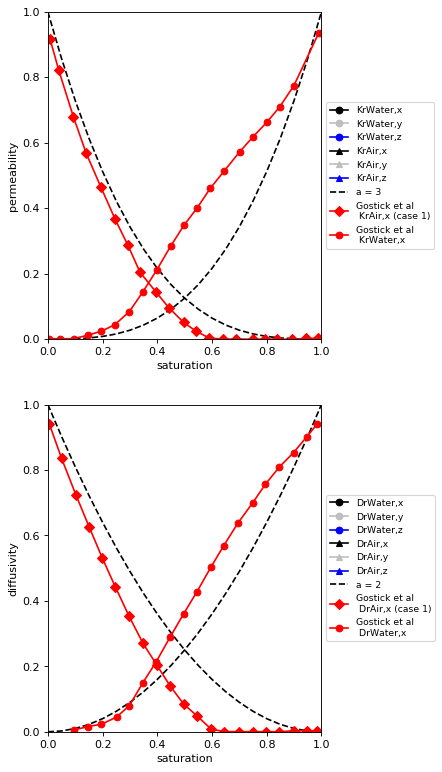

In [17]:
from matplotlib.font_manager import FontProperties
%matplotlib inline

#Data points taken directly from Gostick's graphs using GraphClick
gostick_saturation_1 = [0.008, 0.04, 0.093, 0.14, 0.193, 0.246, 0.293, 0.337, 0.395, 0.442, 0.496,
                        0.542, 0.59, 0.641, 0.687, 0.748, 0.793, 0.838, 0.894, 0.945, 0.986]
gostick_perm_air_case1 = [0.917, 0.821, 0.68, 0.568, 0.466, 0.366, 0.286, 0.204, 0.144, 0.096, 0.051, 0.024,
                          0.003, -1.08E-04, -1.96E-04, -3.12E-04, -3.97E-04, -4.84E-04, -5.90E-04, 0.002, 0.002]
gostick_saturation_2 = [0.99, 0.899, 0.847, 0.802, 0.75, 0.701, 0.645, 0.594, 0.546, 0.497, 0.449,
                        0.398, 0.348, 0.298, 0.245, 0.196, 0.147, 0.094, 0.044, 0.003]
gostick_perm_water = [0.935, 0.774, 0.709, 0.664, 0.618, 0.572, 0.514, 0.461, 0.401, 0.347,
                        0.284, 0.211, 0.145, 0.084, 0.044, 0.024, 0.012, 0.001, 0.001, 0.001]

gostick_saturation_3 =[0.006, 0.05, 0.102, 0.151, 0.199, 0.247, 0.297, 0.348, 0.399, 0.447, 0.496,
                    0.546, 0.597, 0.645, 0.699, 0.75, 0.798, 0.846, 0.899, 0.949, 0.983]
gostick_diff_air_case1 = [0.939, 0.836, 0.725, 0.626, 0.531, 0.442, 0.353, 0.27, 0.203, 0.14, 0.085, 0.048,
                          0.008, 5.49E-04, 4.48E-04, 3.50E-04, 2.59E-04, 1.67E-04, 0.003, 0.003, 0.003]
gostick_saturation_4 = [0.985, 0.946, 0.898, 0.846, 0.795, 0.749, 0.695, 0.643, 0.596, 0.545, 0.496, 0.448,
                        0.396, 0.346, 0.298, 0.251, 0.196, 0.146, 0.094]
gostick_diff_water = [0.941, 0.901, 0.853, 0.809, 0.756, 0.7, 0.638, 0.569, 0.503, 0.428, 0.36, 0.291, 0.214, 1.48E-01,
                      8.00E-02, 4.50E-02, 2.30E-02, 1.60E-02, 0.005]

fontP = FontProperties()
fontP.set_size('small')
#setting up subplots
fig = plt.figure(figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)   #top
ax2 = fig.add_subplot(212)   #bottom

x_values1 = [x/20 for x in range(21)]
z = '.75'


#plots for subplot1 - strict permeability
p1, = ax1.plot(sat, perm_water['0'], color = 'k', linestyle = '-', marker = 'o')
p2, = ax1.plot(sat, perm_water['1'], color = z, linestyle = '-', marker = 'o')
p3, = ax1.plot(sat, perm_water['2'], color = 'b', linestyle = '-', marker = 'o')
p4, = ax1.plot(sat, perm_air['0'], color = 'k', linestyle = '-', marker = '^')
p5, = ax1.plot(sat, perm_air['1'], color = z, linestyle = '-', marker = '^')
p6, = ax1.plot(sat, perm_air['2'], color = 'b', linestyle = '-', marker = '^')
p10, = ax1.plot(x_values1, [x**(3) for x in x_values1], 'k--')
ax1.plot(x_values1, [(1-x)**(3) for x in x_values1], 'k--')
gs1, = ax1.plot(gostick_saturation_1, gostick_perm_air_case1, color = 'r', linestyle = '-', marker = 'D')
gs2, = ax1.plot(gostick_saturation_2, gostick_perm_water, color = 'r', linestyle = '-', marker = 'o')
ax1.set_ylabel('permeability')
ax1.set_xlabel("saturation")
ax1.set_ylim([0,1])
ax1.set_xlim([0,1])

#need to work on legend to match up with the right things
lgd1 = ax1.legend([p1, p2, p3, p4, p5, p6, p10, gs1, gs2],
                  ["KrWater,x", "KrWater,y", "KrWater,z",
                   "KrAir,x","KrAir,y","KrAir,z", "a = 3", 
                   "Gostick et al \n KrAir,x (case 1)", 
                   "Gostick et al \n KrWater,x"], 
                  loc='center left', bbox_to_anchor=(1, 0.5), prop = fontP)

#plots for subplot4 - diffusivity
p11, = ax2.plot(sat, diff_water['0'], color = 'k', linestyle = '-', marker = 'o')
p12, = ax2.plot(sat, diff_water['1'], color = z, linestyle = '-', marker = 'o')
p13, = ax2.plot(sat, diff_water['2'], color = 'b', linestyle = '-', marker = 'o')
p14, = ax2.plot(sat, diff_air['0'], color = 'k', linestyle = '-', marker = '^')
p15, = ax2.plot(sat, diff_air['1'], color = z, linestyle = '-', marker = '^')
p16, = ax2.plot(sat, diff_air['2'], color = 'b', linestyle = '-', marker = '^')
p20, = ax2.plot(x_values1, [x**(2) for x in x_values1], 'k--')
ax2.plot(x_values1, [(1-x)**(2) for x in x_values1], 'k--')
gs3, = ax2.plot(gostick_saturation_3, gostick_diff_air_case1, color = 'r', linestyle = '-', marker = 'D')
gs4, = ax2.plot(gostick_saturation_4, gostick_diff_water, color = 'r', linestyle = '-', marker = 'o')
ax2.set_ylabel('diffusivity')
ax2.set_xlabel("saturation")
ax2.set_ylim([0,1])
ax2.set_xlim([0,1])

lgd2 = ax2.legend([p11, p12, p13, p14, p15, p16, p20, gs3, gs4],
                  ["DrWater,x", "DrWater,y", "DrWater,z",
                   "DrAir,x","DrAir,y","DrAir,z", "a = 2", 
                   "Gostick et al \n DrAir,x (case 1)", 
                   "Gostick et al \n DrWater,x"], 
                  loc='center left', bbox_to_anchor=(1, 0.5), prop = fontP)

fig.subplots_adjust(left=0.13, right=.7, top=0.95, bottom=0.05)

plt.show()

## Discrepancies with Gostick's simulation
Several things contribute to slight differences between this simulation and that produced by Gostick et al in their 2007 paper.  These include:

1. lack of pore size correlation
2. lack of late pore filling

## Acknowledgements
The OpenPNM team would like to thank Jackie Lunger (Materials Science and Engineering, University of Toronto, 1T7) for her excellent work in developing this example.